<a href="https://colab.research.google.com/github/Ludvins/Practicas_PDGE/blob/master/CUDA/Multiplicacion_matrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Luis Antonio Ortega Andrés    
Antonio Coín Castro*

# Ejercicio opcional: multiplicación de matrices

Consideramos el problema de multiplicar dos matrices cuadradas $A$ y $B$ de dimensiones $N\times N$, obteniendo como resultado una matriz $C$, también $N\times N$.

## Multiplicación en CPU

Realizamos la multiplicación en CPU, cuya eficiencia es $O(N^3)$. 

In [ ]:
%%writefile matmul_cpu.cu

#include <stdio.h>

#define N 64

void matrixMultCPU(float a[N][N], float b[N][N], float c[N][N]) {
  int i, j, k;
  for (i=0; i < N; i++) {
    for (j = 0; j < N; j++) {
      float sum = 0;
      for (k = 0; k < N; k++) {
        sum += a[i][k] * b[k][j];
      }
      c[i][j] = sum;
    }
  }
}

int main() {
  float a[N][N], b[N][N], c[N][N];

  cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);

  /* inicializando variables con datos*/
  for (int i = 0; i < N; i++) {
    for (int j = 0; j < N; j++) {
      a[i][j] = 1.0;
      b[i][j] = 2.0;
    }
  }

  int nIter=1000;
  cudaEventRecord(start);
  for (int i = 0; i < nIter; i++)
    matrixMultCPU(a, b, c);

  cudaEventRecord(stop);
  cudaEventSynchronize(stop);

  float msecTotal = 0.0;
  cudaEventElapsedTime(&msecTotal, start, stop);

  // Comprueba resultados
  int errores = 0;
  for (int y = 0; y < N; y++) {
    for (int x = 0; x < N; x++) {
        if (c[y][x] != 2*N) {
          errores++;
        }
    }
  }

  printf("Producto de matrices %d x %d\n", N, N);
  printf("Resultado ");
  if (errores == 0){
    printf("correcto\n");
  }
  else {
    printf("incorrecto. Errores: %d\n", errores);
    return 1;
  }

  float msecPerKernelExecution = msecTotal / nIter;
  double flopsPerMMull = 2.0 * N * N * N;
  double gigaFlops = (flopsPerMMull * 1.0e-9) /
    (msecPerKernelExecution / 1000.0);

  printf("Tiempo medio de ejecución: %f ms\n", msecPerKernelExecution);
  printf("GFLOPS: %f\n", gigaFlops);
  return 0;
}

Overwriting matmul_cpu.cu


In [ ]:
!/usr/local/cuda/bin/nvcc -arch=sm_35 -rdc=true matmul_cpu.cu -o matmul_cpu -lcudadevrt
!./matmul_cpu

Producto de matrices 64 x 64
Resultado correcto
Tiempo medio de ejecución: 0.835759 ms
GFLOPS: 0.627320


## Multiplicación en GPU

Pasamos ahora a realizar la misma implementación pero en GPU. La adaptamos para un tamaño $N$ arbitrario, empleando siempre bloques de $8\times 8$ threads (para aprovechar al máximo el paralelismo, como ya comentamos en el ejercicio sobre la suma de matrices), y un número de bloques igual a $(N+7)/8$. Diferenciamos según si se utiliza memoria compartida o no.

### Sin usar memoria compartida

Implementamos en primer lugar el algoritmo más sencillo. Establecemos una estructura bidimensional de bloques y threads, y el thread con identificador $(i, j)$ (en coordenadas de grid) procesa la fila $j$-ésima y la columna $i$-ésima para obtener el elemento $C_{ij}$. De esta forma obtenemos del orden de $N^2$ threads, donde cada uno realiza $O(N)$ operaciones.

In [ ]:
%%writefile matmul_gpu_v1.cu

#include <stdio.h>

#define N 64
#define TPB 8

// Computa la multiplicación de matrices en GPU sin memoria compartida
__global__ void matrixMultGPU(int n, float *a, float *b, float *c) {
  int k;
  float sum = 0;
  int col = threadIdx.x + blockDim.x * blockIdx.x;
  int row = threadIdx.y + blockDim.y * blockIdx.y;
  
  if (row < n && col < n) {
    for (k = 0; k < n; k++) {
      sum += a[row * n + k] * b[k * n + col];
    }
    c[row * n + col] = sum;
  }
}

int main() {
  float a[N][N], b[N][N], c[N][N];
  float *dev_a, *dev_b, *dev_c;
  int size = N * N * sizeof(float);

  cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);

  cudaMalloc((void **) &dev_a, size);
  cudaMalloc((void **) &dev_b, size);
  cudaMalloc((void **) &dev_c, size);

  // inicializando variables
  for (int i = 0; i < N; i++) {
    for (int j = 0; j < N; j++) {
      a[i][j] = 1.0;
      b[i][j] = 2.0;
    }
  }

  cudaMemcpy(dev_a, a, size, cudaMemcpyHostToDevice);
  cudaMemcpy(dev_b, b, size, cudaMemcpyHostToDevice);

  // Tamaño de grid y bloque
  dim3 dimGrid((N+TPB-1)/TPB, (N+TPB-1)/TPB);
  dim3 dimBlock(TPB, TPB);

  int nIter=1000;
  cudaEventRecord(start);
  for (int i=0; i <nIter; i++) {
    matrixMultGPU<<<dimGrid, dimBlock>>>(N, dev_a, dev_b, dev_c);
  }
  cudaEventRecord(stop);
  cudaEventSynchronize(stop);

  cudaMemcpy(c, dev_c, size, cudaMemcpyDeviceToHost);

  float msecTotal = 0.0;
  cudaEventElapsedTime(&msecTotal, start, stop);

  // Comprueba resultados
  int errores = 0;
  for (int y = 0; y < N; y++) {
    for (int x = 0; x < N; x++) {
        if (c[y][x] != 2*N) {
          errores++;
          //printf("[%d][%d]=%f en vez de %d; ", y, x, c[y][x], 2*N);
        }
    }
    //printf("\n");
  }

  cudaFree(dev_a);
  cudaFree(dev_b);
  cudaFree(dev_c);

  printf("Producto de matrices %d x %d\n", N, N);
  printf("Resultado ");
  if (errores == 0){
    printf("correcto\n");
  }
  else {
    printf("incorrecto. Errores: %d\n", errores);
    return 1;
  }

  float msecPerKernelExecution = msecTotal / nIter;
  double flopsPerMMull = 2.0 * N * N * N;
  double gigaFlops = (flopsPerMMull * 1.0e-9) /
    (msecPerKernelExecution / 1000.0);

  printf("GFLOPS: %f\n", gigaFlops);

  return 0;
}

Overwriting matmul_gpu_v1.cu


In [ ]:
!/usr/local/cuda/bin/nvcc -arch=sm_35 -rdc=true matmul_gpu_v1.cu -o matmul_gpu_v1 -lcudadevrt
!nvprof ./matmul_gpu_v1

==3491== NVPROF is profiling process 3491, command: ./matmul_gpu_v1
Producto de matrices 64 x 64
Resultado correcto
GFLOPS: 56.663803
==3491== Profiling application: ./matmul_gpu_v1
==3491== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   99.89%  7.9497ms      1000  7.9490us  7.8720us  12.641us  matrixMultGPU(int, float*, float*, float*)
                    0.07%  5.6320us         2  2.8160us  2.6560us  2.9760us  [CUDA memcpy HtoD]
                    0.04%  2.9120us         1  2.9120us  2.9120us  2.9120us  [CUDA memcpy DtoH]
      API calls:   94.48%  168.93ms         2  84.466ms  1.2010us  168.93ms  cudaEventCreate
                    3.63%  6.4997ms      1000  6.4990us  4.4100us  36.539us  cudaLaunchKernel
                    1.36%  2.4318ms         1  2.4318ms  2.4318ms  2.4318ms  cudaEventSynchronize
                    0.21%  373.90us         1  373.90us  373.90us  373.90us  cuDeviceTotalMem
                  

Vemos que se realiza adecuadamente el producto y no se producen errores. Además, el tiempo medio por ejecución es de tan solo 8 us, muy por debajo del tiempo medio de ejecución en CPU.

## Memoria compartida con optimizaciones adicionales

Pasamos ahora a optimizar la forma de cálculo del producto. En concreto hacemos tres optimizaciones:

- Utilizamos memoria compartida para el acceso a los datos. De esta forma, definiremos "mosaicos" para hacer el producto de matrices por bloques, de manera independiente y optimizando el acceso a memoria. Así conseguimos que las matrices $A$ y $B$ se carguen solo $N/8$ veces en memoria, al contrario que antes que se cargaban $N$ veces. Necesitamos usar `__syncthreads()` para asegurarnos de que todos los datos necesarios han sido cargados.
- Accedemos a los mosaicos de forma traspuesta para aumentar la eficiencia en memoria, debido a que se guardan en "column-major".
- Desenrrollamos bucles para optimización del compilador. Utilizamos la directiva del precompilador `#pragma unroll`.

También añadimos una mejora, y es que, además de permitir tamaños arbitrariamente grandes de $N$ (limitados solo por el tamaño máximo de grid), **permitimos que no tenga que ser potencia de 2**. En este caso debemos asegurarnos que los mosaicos que solo estén parcialmente rellenos tengan a 0 el resto de sus posiciones, para no influir en el cálculo. Como siempre, debemos comprobar que los índices en el acceso a matrices sean correctos.

In [ ]:
%%writefile matmul_gpu_v2.cu

#include <stdio.h>

#define N 64
#define TPB 8

__global__ void matrixMultGPU2(int n, float* A, float* B, float* C) {
    float sum = 0;
    int tile;
    int tx = threadIdx.x;
    int ty = threadIdx.y;
    int i = blockIdx.x * blockDim.x + tx;
    int j = blockIdx.y * blockDim.y + ty;

      // Mosaicos en memoria de bloque
      __shared__ float As[TPB][TPB];
      __shared__ float Bs[TPB][TPB];

      // Recorre los mosaicos de A y B necesarios para computar la submatriz de C
      for (tile = 0; tile < (n+TPB-1)/TPB; tile++){
          // Carga los mosaicos de A y B en paralelo (y de forma traspuesta)
          if ((ty + (tile*TPB))<n && i < n)
            As[ty][tx] = A[(i * n) + (ty + (tile*TPB))];
          else
            As[ty][tx] = 0.0;
          if ((tx + (tile*TPB))<n && j < n)
            Bs[ty][tx] = B[((tx + (tile * TPB))*n) + j];
          else
            Bs[ty][tx] = 0.0;

            __syncthreads();

            // Computa los resultados para la submatriz de C (también traspuestos)
    #pragma unroll
            for (int k = 0; k < TPB; k++)
              sum += As[k][tx] * Bs[ty][k];

            __syncthreads();
      }
      // Escribe en paralelo los resultados obtenidos por el bloque
      if (i < n && j < n)
        C[i * n + j] = sum;
}

int main() {
  float a[N][N], b[N][N], c[N][N];
  float *dev_a, *dev_b, *dev_c;
  int size = N * N * sizeof(float);

  cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);

  cudaMalloc((void **) &dev_a, size);
  cudaMalloc((void **) &dev_b, size);
  cudaMalloc((void **) &dev_c, size);

  // inicializando variables
  for (int i = 0; i < N; i++) {
    for (int j = 0; j < N; j++) {
      a[i][j] = 1.0;
      b[i][j] = 2.0;
    }
  }

  cudaMemcpy(dev_a, a, size, cudaMemcpyHostToDevice);
  cudaMemcpy(dev_b, b, size, cudaMemcpyHostToDevice);

  // Tamaño de grid y bloque
  dim3 dimGrid((N+TPB-1)/TPB, (N+TPB-1)/TPB);
  dim3 dimBlock(TPB, TPB);

  int nIter=1000;
  cudaEventRecord(start);
  for (int i=0; i <nIter; i++) {
    matrixMultGPU2<<<dimGrid, dimBlock>>>(N, dev_a, dev_b, dev_c);
  }
  cudaEventRecord(stop);
  cudaEventSynchronize(stop);

  cudaMemcpy(c, dev_c, size, cudaMemcpyDeviceToHost);

  float msecTotal = 0.0;
  cudaEventElapsedTime(&msecTotal, start, stop);

  // Comprueba resultados
  int errores = 0;
  for (int y = 0; y < N; y++) {
    for (int x = 0; x < N; x++) {
        if (c[y][x] != 2*N) {
          errores++;
          //printf("[%d][%d]=%f en vez de %d; ", y, x, c[y][x], 2*N);
        }
    }
    //printf("\n");
  }

  cudaFree(dev_a);
  cudaFree(dev_b);
  cudaFree(dev_c);

  printf("Producto de matrices %d x %d\n", N, N);
  printf("Resultado ");
  if (errores == 0){
    printf("correcto\n");
  }
  else {
    printf("incorrecto. Errores: %d\n", errores);
    return 1;
  }

  float msecPerKernelExecution = msecTotal / nIter;
  double flopsPerMMull = 2.0 * N * N * N;
  double gigaFlops = (flopsPerMMull * 1.0e-9) /
    (msecPerKernelExecution / 1000.0);

  printf("GFLOPS: %f\n", gigaFlops);

  return 0;
}

Overwriting matmul_gpu_v2.cu


In [ ]:
!/usr/local/cuda/bin/nvcc -arch=sm_35 -rdc=true matmul_gpu_v2.cu -o matmul_gpu_v2 -lcudadevrt
!./matmul_gpu_v2

Producto de matrices 64 x 64
Resultado correcto
GFLOPS: 55.592693


Podemos probar a incrementar el tamaño de las matrices, modificarlo para que no sean potencia de 2, e incluso variar el número de hilos por bloque. Comprobamos que en todo caso el resultado obtenido con esta versión sigue siendo correcto.

In [ ]:
!sed -i '/#define N/c\#define N 200' matmul_gpu_v2.cu
!sed -i '/#define TPB/c\#define TPB 32' matmul_gpu_v2.cu
!/usr/local/cuda/bin/nvcc -arch=sm_35 -rdc=true matmul_gpu_v2.cu -o matmul_gpu_v2 -lcudadevrt
!./matmul_gpu_v2

Producto de matrices 200 x 200
Resultado correcto
GFLOPS: 105.132073


## Medición de tiempos

Medimos los tiempos medios de ejecución (en 1000 ejecuciones) y los GFLOPS con/sin optimizaciones, usando tamaños de bloque $TPB=8$ y $TPB=32$.

### Sin memoria compartida

In [ ]:
!sed -i '/#define TPB/c\#define TPB 8' matmul_gpu_v1.cu
!for i in 16 32 64 128 512; do sed -i "/#define N/c\#define N $i" matmul_gpu_v1.cu && /usr/local/cuda/bin/nvcc -arch=sm_35 -rdc=true matmul_gpu_v1.cu -o matmul_gpu_v1 -lcudadevrt && nvprof ./matmul_gpu_v1; done

**Sin memoria compartida, bloques de $8\times 8$, tiempos medios en $\mu$sec**

| Tamaño de matriz | CPU->GPU | GPU -> CPU | Ejecución | Ratio comparado con 128x128 | GFLOPs     |
|:------------------:|:----------:|:------------:|:-----------:|:-----------------------------:|:------------:|
| 16x16            | 1.66   | 1.88   | 2.77    |          0.01                   | 1.19   |
| 32x32            | 1.87  | 2.01    | 3.69   |               0.09              | 11.09  |
| 64x64            | 2.8  | 2.91    | 7.95   |              0.41               | 49.46     |
| 128x128          | 6.91  | 6.84    | 34.01  |                 1            | 118.93 |
| 512x512          | 89.63 | 84.51   | 856.27   |                 2.63            | 313.22 |

In [ ]:
!sed -i '/#define TPB/c\#define TPB 32' matmul_gpu_v1.cu
!for i in 16 32 64 128 512; do sed -i "/#define N/c\#define N $i" matmul_gpu_v1.cu && /usr/local/cuda/bin/nvcc -arch=sm_35 -rdc=true matmul_gpu_v1.cu -o matmul_gpu_v1 -lcudadevrt && nvprof ./matmul_gpu_v1; done

**Sin memoria compartida, bloques de $32\times 32$, tiempos medios en $\mu$sec**

| Tamaño de matriz | CPU->GPU | GPU -> CPU | Ejecución | Ratio comparado con 128x128 | GFLOPs     |
|:------------------:|:----------:|:------------:|:-----------:|:-----------------------------:|:------------:|
| 16x16            | 1.34  | 1.34   | 1.76    |          0.01                  | 1.28   |
| 32x32            | 2.01 | 2.01    | 9.88   |               0.04              | 5.87  |
| 64x64            | 2.78 | 2.91    | 17.07   |              0.22               | 28.54     |
| 128x128          | 6.70  | 6.81    | 31.46  |                 1            | 128.26 |
| 512x512          | 89.93 | 80.93   | 478.87   |                 4.36            | 559.59 |

Vemos que en general con bloques de $8\times 8$ las operaciones son más rápidas hasta tamaño $128\times 128$, donde comienza a ser más veloz utilizar bloques de $32\times 32$ hilos.

Los tiempos de copia de datos CPU->GPU y viceversa son bastante similares, entre sí y para los dos tamaños de bloque analizados. El cuello de botella es el ancho de banda a la hora del acceso a memoria.

### Con memoria compartida y optimizaciones




In [ ]:
!sed -i '/#define TPB/c\#define TPB 8' matmul_gpu_v2.cu
!for i in 16 32 64 128 512; do sed -i "/#define N/c\#define N $i" matmul_gpu_v2.cu && /usr/local/cuda/bin/nvcc -arch=sm_35 -rdc=true matmul_gpu_v2.cu -o matmul_gpu_v2 -lcudadevrt && nvprof ./matmul_gpu_v2; done

**Con memoria compartida, bloques de $8\times 8$, tiempos medios en $\mu$sec**

| Tamaño de matriz | CPU->GPU | GPU -> CPU | Ejecución | Ratio comparado con 128x128 | GFLOPs     |
|:------------------:|:----------:|:------------:|:-----------:|:-----------------------------:|:------------:|
| 16x16            | 1.52  | 1.34   | 1.48    |          0.008                  | 1.02   |
| 32x32            | 1.90 | 2.01    | 4.56   |               0.09              | 11.12  |
| 64x64            | 2.80 | 2.88   | 8.3   |              0.45               | 54.98     |
| 128x128          | 6.83  | 6.88    | 33.49  |                 1            | 120.78 |
| 512x512          | 90.91 | 80.83   | 822.93  |                 2.7            | 325.90 |

In [ ]:
!sed -i '/#define TPB/c\#define TPB 32' matmul_gpu_v2.cu
!for i in 16 32 64 128 512; do sed -i "/#define N/c\#define N $i" matmul_gpu_v2.cu && /usr/local/cuda/bin/nvcc -arch=sm_35 -rdc=true matmul_gpu_v2.cu -o matmul_gpu_v2 -lcudadevrt && nvprof ./matmul_gpu_v2; done

**Con memoria compartida, bloques de $32\times 32$, tiempos medios en $\mu$sec**

| Tamaño de matriz | CPU->GPU | GPU -> CPU | Ejecución | Ratio comparado con 128x128 | GFLOPs     |
|:------------------:|:----------:|:------------:|:-----------:|:-----------------------------:|:------------:|
| 16x16            | 1.34  | 1.34   | 4.11    |          0.01                  | 1.30   |
| 32x32            | 1.90 | 2.08    | 17.07   |               0.04             | 3.57  |
| 64x64            | 2.83| 2.97   | 28.45   |              0.22               | 17.59     |
| 128x128          | 6.86  | 6.94    | 51.28  |                 1            | 79.83 |
| 512x512          | 92.37 | 97.34   | 795.86  |                 4.26            | 336.99 |

En este caso observamos el mismo fenómeno que anteriormente: las operaciones con bloques de $8\times 8$ son más rápidas en general, excepto en el caso de matrices $512\times 512$, donde los bloques de $32\times 32$ consiguen una pequeña mejora.

Comparando estas versiones con las correspondientes que no utilizan memoria compartida, vemos que la aceleración se obtiene solo para tamaños grandes de matrices. Sin embargo, hay una excepción: en el caso de tamaño de bloque $32\times 32$ obtenemos unos 330 GFLOPS usando memoria compartida, y más de 550 GFLOPS sin usarla.

También podemos ver que el incremento en el ratio (frente a tamaño $128\times 128$) es más sustancial en el caso de $512\times 512$, lo que refuerza la idea de que se obtiene mayor aceleración para tamaños más grandes de matrices.

Podemos resumir la información de todas las tablas en una gráfica.

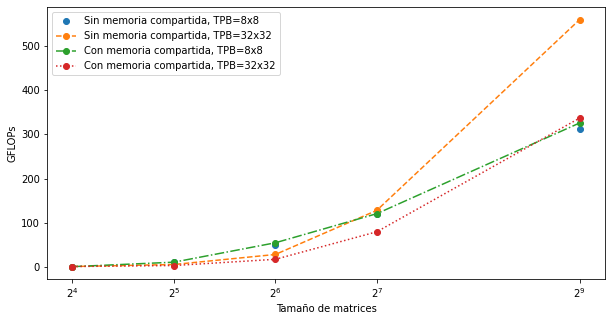

In [ ]:
import matplotlib.pyplot as plt

x=[16, 32, 64, 128, 512]
y1=[1.19, 11.09, 49.46, 118.93, 313.22]
y2=[1.28, 5.87, 28.54, 128.26, 559.59]
y3=[1.02, 11.12, 54.98, 120.78, 325.90]
y4=[1.30, 3.57, 17.59, 79.83,336.99]

plt.figure(figsize=(10, 5))
plt.plot(x, y1, "o", label="Sin memoria compartida, TPB=8x8")
plt.plot(x, y2, "--o", label="Sin memoria compartida, TPB=32x32")
plt.plot(x, y3, "-.o", label="Con memoria compartida, TPB=8x8")
plt.plot(x, y4, ":o", label="Con memoria compartida, TPB=32x32")
plt.xscale('log', basex=2)
plt.xticks(x)
plt.xlabel("Tamaño de matrices")
plt.ylabel("GFLOPs")
plt.legend()
plt.show()

Vemos cómo destaca la aceleración para matrices de tamaño más alto, y a excepción del caso $512\times 512$ de la curva amarilla sin memoria compartida, nuestra última versión con memoria compartida y tamaño de bloque $32\times 32$ es la que se impone para tamaños grandes de las matrices.

### Otro tipo de dato

Usamos matrices de tipo `double` en vez de `float`.

In [ ]:
!sed 's/float/double/g' matmul_gpu_v2.cu > matmul_gpu_v2_double.cu
!sed -i '/double msecTotal = 0.0/c\float msecTotal = 0.0;' matmul_gpu_v2_double.cu

Medimos los tiempos en este caso, con memoria compartida y fijando $TPB=32$.

In [ ]:
!sed -i '/#define TPB/c\#define TPB 32' matmul_gpu_v2_double.cu
!for i in 16 32 64 128 512; do sed -i "/#define N/c\#define N $i" matmul_gpu_v2_double.cu && /usr/local/cuda/bin/nvcc -arch=sm_35 -rdc=true matmul_gpu_v2_double.cu -o matmul_gpu_v2_double -lcudadevrt && nvprof ./matmul_gpu_v2_double; done

**Con memoria compartida, bloques de $32\times 32$, tipo de dato `double`, tiempos medios en $\mu$sec**

| Tamaño de matriz | CPU->GPU | GPU -> CPU | Ejecución | Ratio comparado con 128x128 | GFLOPs     |
|:------------------:|:----------:|:------------:|:-----------:|:-----------------------------:|:------------:|
| 16x16            | 1.36  | 1.37   | 12.28    |          0.02                  | 0.63   |
| 32x32            | 2.20 | 2.30    | 37.60   |               0.05             | 1.68  |
| 64x64            | 4.17 | 4.44   | 69.33   |              0.24               | 7.42     |
| 128x128          | 14.30  | 12.41    |132.86  |                 1            | 31.27 |
| 512x512          | 329.74 | 164.04   | 1581.2  |                 5.44            | 169.69 |

Si comparamos esta tabla con la correspondiente al caso de memoria compartida y bloques de $32\times 32$ usando floats, vemos que los tiempos de ejecución son aproximadamente el doble, y por tanto los GLOPS descienden hasta algo más de la mitad. Esto tiene sentido, ya que el tamaño de un `double` es 8 bytes, mientras que el de un `float` es 4 bytes. Como el cuello de botella era precisamente el ancho de banda de memoria, este cambio ralentiza nuestros programas.

Sin embargo, cabe destacar que en este caso es donde conseguimos el mayor ratio en GFLOPS de $512\times 512$ comparado con $128\times 128$, llegando a ser más de 5 veces mayor.

### Comparación con el programa de ejemplo de CUDA

Finalmente, comparamos los resultados con el programa de ejemplo *built-in* que proporciona CUDA para hacer el producto de matrices. Lo hacemos con los parámetros por defecto (usa bloques de $32\times 32$) y con un tamaño de matrices de $512\times 512$.

In [ ]:
%cd /usr/local/cuda/samples/0_Simple/matrixMul
!make

/usr/local/cuda-10.1/samples/0_Simple/matrixMul
/usr/local/cuda-10.1/bin/nvcc -ccbin g++   -m64      -gencode arch=compute_30,code=sm_30 -gencode arch=compute_35,code=sm_35 -gencode arch=compute_37,code=sm_37 -gencode arch=compute_50,code=sm_50 -gencode arch=compute_52,code=sm_52 -gencode arch=compute_60,code=sm_60 -gencode arch=compute_61,code=sm_61 -gencode arch=compute_70,code=sm_70 -gencode arch=compute_75,code=sm_75 -gencode arch=compute_75,code=compute_75 -o matrixMul matrixMul.o 
mkdir -p ../../bin/x86_64/linux/release
cp matrixMul ../../bin/x86_64/linux/release


In [ ]:
!nvprof ./matrixMul -wA=512 -wB=512 -hA=512 -hB=512

[Matrix Multiply Using CUDA] - Starting...
==5088== NVPROF is profiling process 5088, command: ./matrixMul -wA=512 -wB=512 -hA=512 -hB=512
GPU Device 0: "Tesla T4" with compute capability 7.5

MatrixA(512,512), MatrixB(512,512)
Computing result using CUDA Kernel...
done
Performance= 1012.51 GFlop/s, Time= 0.265 msec, Size= 268435456 Ops, WorkgroupSize= 1024 threads/block
Checking computed result for correctness: Result = PASS

NOTE: The CUDA Samples are not meant for performancemeasurements. Results may vary when GPU Boost is enabled.
==5088== Profiling application: ./matrixMul -wA=512 -wB=512 -hA=512 -hB=512
==5088== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   99.66%  79.597ms       301  264.44us  259.91us  270.44us  void MatrixMulCUDA<int=32>(float*, float*, float*, int, int)
                    0.24%  191.78us         2  95.891us  88.387us  103.40us  [CUDA memcpy HtoD]
                    0.10%  80.611us     

Vemos que en este caso se alcanzan los 1000 GFLOPS, superando por mucho a todos nuestros intentos anteriores.

## Bonus: extensión a matrices no cuadradas

Finalmente hacemos las modificaciones necesarias para tener una versión definitiva que permita multiplicar matrices de cualquier dimensión, sean o no tamaño potencia de 2. El único requisito es que tengan dimensiones compatibles para hacer el producto.

In [68]:
%%writefile matmul_gpu_v3.cu

#include <stdio.h>

#define RA 512
#define CA 120
#define RB 120
#define CB 250
#define TPB 32

__global__ void matrixMultGPU3(int rA, int cA, int rB, int cB, 
                               float* A, float* B, float* C) {
    float sum = 0;
    int tile;
    int tx = threadIdx.x;
    int ty = threadIdx.y;
    int i = blockIdx.x * blockDim.x + tx;
    int j = blockIdx.y * blockDim.y + ty;

      // Mosaicos en memoria de bloque
      __shared__ float As[TPB][TPB];
      __shared__ float Bs[TPB][TPB];

      // Recorre los mosaicos de A y B necesarios para computar la submatriz de C
      for (tile = 0; tile < (cA+TPB-1)/TPB; tile++){
          // Carga los mosaicos de A y B en paralelo (y de forma traspuesta)
          if ((ty + (tile*TPB))< cA && i < rA)
            As[ty][tx] = A[(i * cA) + (ty + (tile*TPB))];
          else
            As[ty][tx] = 0.0;
          if ((tx + (tile*TPB))<rB && j < cB)
            Bs[ty][tx] = B[((tx + (tile * TPB))*cB) + j];
          else
            Bs[ty][tx] = 0.0;

            __syncthreads();

            // Computa los resultados para la submatriz de C (también traspuestos)
    #pragma unroll
            for (int k = 0; k < TPB; k++)
              sum += As[k][tx] * Bs[ty][k];

            __syncthreads();
      }
      // Escribe en paralelo los resultados obtenidos por el bloque
      if (i < rA && j < cB)
        C[i * cB + j] = sum;
}

int main() {
    
  if (CA != RB) {
      printf("[Error] Las dimensiones de las matrices no son compatibles.\n");
      return 1;
  }
  float a[RA][CA], b[RB][CB], c[RA][CB];
  float *dev_a, *dev_b, *dev_c;
  int sizeA = RA * CA * sizeof(float);
  int sizeB = RB * CB * sizeof(float);
  int sizeC = RA * CB * sizeof(float);

  cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);

  cudaMalloc((void **) &dev_a, sizeA);
  cudaMalloc((void **) &dev_b, sizeB);
  cudaMalloc((void **) &dev_c, sizeC);

  // inicializando variables
  for (int i = 0; i < RA; i++) {
    for (int j = 0; j < CA; j++) {
      a[i][j] = 1.0;
    }
  }

  for (int i = 0; i < RB; i++) {
    for (int j = 0; j < CB; j++) {
      b[i][j] = 2.0;
    }
  }

  cudaMemcpy(dev_a, a, sizeA, cudaMemcpyHostToDevice);
  cudaMemcpy(dev_b, b, sizeB, cudaMemcpyHostToDevice);

  // Tamaño de grid y bloque
  dim3 dimGrid((RA+TPB-1)/TPB, (CB+TPB-1)/TPB);
  dim3 dimBlock(TPB, TPB);

  int nIter=1000;
  cudaEventRecord(start);
  for (int i=0; i <nIter; i++) {
    matrixMultGPU3<<<dimGrid, dimBlock>>>(RA, CA, RB, CB, dev_a, dev_b, dev_c);
  }
  cudaEventRecord(stop);
  cudaEventSynchronize(stop);

  cudaMemcpy(c, dev_c, sizeC, cudaMemcpyDeviceToHost);

  float msecTotal = 0.0;
  cudaEventElapsedTime(&msecTotal, start, stop);

  // Comprueba resultados
  int errores = 0;
  for (int i = 0; i < RA; i++) {
    for (int j = 0; j < CB; j++) {
        //printf("c[%d][%d]=%f; ", i, j, c[i][j]);
        if (c[i][j] != 2*CA) {
          errores++;
        }
    }
  }

  cudaFree(dev_a);
  cudaFree(dev_b);
  cudaFree(dev_c);

  printf("Producto de matrices %d x %d y %d x %d\n", RA, CA, RB, CB);
  printf("Resultado ");
  if (errores == 0){
    printf("correcto\n");
  }
  else {
    printf("incorrecto. Errores: %d\n", errores);
    return 1;
  }

  float msecPerKernelExecution = msecTotal / nIter;
  double flopsPerMMull = 2.0 * RA * CA * CB;
  double gigaFlops = (flopsPerMMull * 1.0e-9) /
    (msecPerKernelExecution / 1000.0);

  printf("GFLOPS: %f\n", gigaFlops);

  return 0;
}

Overwriting matmul_gpu_v3.cu


Ejecutamos el programa y vemos que los tiempos de suma son similares a los correspondientes de la versión anterior.

In [69]:
!/usr/local/cuda/bin/nvcc -arch=sm_35 -rdc=true matmul_gpu_v3.cu -o matmul_gpu_v3 -lcudadevrt
!nvprof ./matmul_gpu_v3

==2364== NVPROF is profiling process 2364, command: ./matmul_gpu_v3
Producto de matrices 512 x 120 y 120 x 250
Resultado correcto
GFLOPS: 177.525532
==2364== Profiling application: ./matmul_gpu_v3
==2364== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   99.96%  171.88ms      1000  171.88us  109.82us  199.65us  matrixMultGPU3(int, int, int, int, float*, float*, float*)
                    0.02%  40.832us         1  40.832us  40.832us  40.832us  [CUDA memcpy DtoH]
                    0.02%  36.160us         2  18.080us  12.544us  23.616us  [CUDA memcpy HtoD]
      API calls:   51.78%  187.13ms         2  93.564ms     960ns  187.13ms  cudaEventCreate
                   46.29%  167.29ms         1  167.29ms  167.29ms  167.29ms  cudaEventSynchronize
                    1.51%  5.4660ms      1000  5.4660us  4.5650us  29.456us  cudaLaunchKernel
                    0.15%  525.29us         3  175.10us  64.146us  395.51us  cuda